### Imports

In [1]:
import seaborn as sns
import numpy
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import os
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam 
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import warnings
from sklearn.metrics import f1_score 
warnings.filterwarnings("ignore")

#### Importing Directories

In [2]:
path_train='Brain-Tumor/Training/'
path_test='Brain-Tumor/Testing/'

In [3]:
os.listdir(path_train)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [4]:
train_img = []
train_labels = []

test_img = []
test_labels = []

img_size= 300

for i in os.listdir(path_train):
    for j in os.listdir(path_train+i):
        train_img.append (cv2.resize(cv2.imread(path_train+i+'/'+j), (img_size,img_size))) 
        train_labels.append(i)
        
for i in os.listdir(path_test):
    for j in os.listdir(path_test+i):
        test_img.append (cv2.resize(cv2.imread(path_test+i+'/'+j), (img_size,img_size))) 
        test_labels.append(i)
        
train_img = (np.array(train_img))
test_img = (np.array(test_img))

In [5]:
glioma_tumor= [i for i in os.listdir(f'{path_train}/glioma_tumor') if i.endswith('.jpg')]
meningioma_tumor= [i for i in os.listdir(f'{path_train}/meningioma_tumor') if i.endswith('.jpg')]
pituitary_tumor= [i for i in os.listdir(f'{path_train}/pituitary_tumor') if i.endswith('.jpg')]
no_tumor= [i for i in os.listdir(f'{path_train}/no_tumor') if i.endswith('.jpg')]

In [6]:
Labels=['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
SizeofTrain=[len(glioma_tumor),len(meningioma_tumor),len(pituitary_tumor),len(no_tumor)]

In [7]:
print("Shape of train: ",train_img.shape, " and shape of test: ", test_img.shape)

Shape of train:  (2870, 300, 300, 3)  and shape of test:  (394, 300, 300, 3)


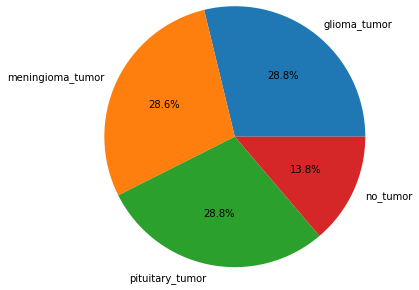

In [8]:
#Plot of the categories in the training Set
plt.pie(SizeofTrain, labels=Labels, autopct = '%1.1f%%', radius = 1.5)
plt.show()

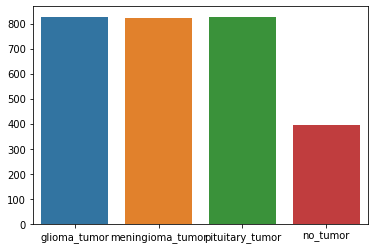

In [9]:
values = [len(glioma_tumor), len(meningioma_tumor), len(pituitary_tumor), len(no_tumor)]
sns.barplot(x = Labels, y = values)
plt.show()

The dataset is balanced: 3 classes are approxiamtely with the same size, only the no-tumor class contains less images than the other categories we can remediate to that.

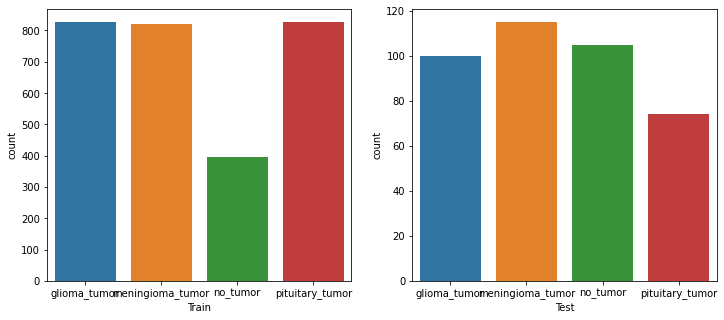

In [10]:
plt.figure(figsize = (12,5))
list = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(list[i])

### Visualizations 

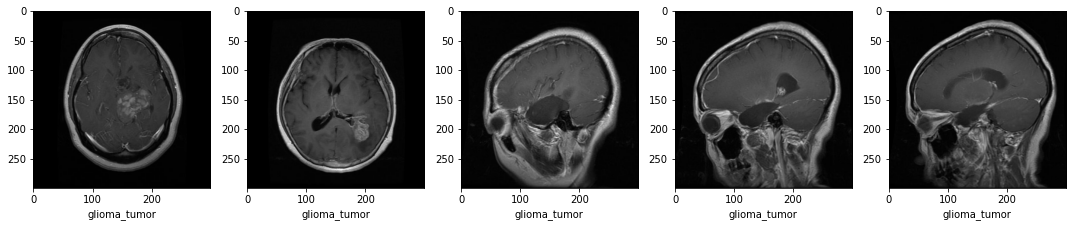

In [11]:
plt.figure(figsize = (15,15));
for i,j in enumerate(train_img):
    if i<5:
        plt.subplot(1,5,i+1)
        plt.imshow(j);
        plt.xlabel(train_labels[i]);
        plt.tight_layout()
    else:
        break

In [12]:
transforming_img = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

In [13]:
train_x, val_x, train_y, val_y = train_test_split(np.array(train_img), np.array(train_labels), test_size = 0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((2583, 300, 300, 3), (2583,), (287, 300, 300, 3), (287,))

In [14]:
test_x, val_x, test_y, val_y = train_test_split(np.array(test_img), np.array(test_labels), test_size = 0.1)
test_x.shape, test_y.shape, val_x.shape, val_y.shape

((354, 300, 300, 3), (354,), (40, 300, 300, 3), (40,))

In [15]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(path_train,transform=transforming_img),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(path_test,transform=transforming_img),
    batch_size=32, shuffle=True
)

#categories
root=pathlib.Path(path_train)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [16]:
print(f'The classes are: {classes}')

The classes are: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


### Model

In [17]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
class BrainTumorModel(nn.Module):
    def __init__(self):
        super(BrainTumorModel, self).__init__()
        self.C1=torch.nn.Conv2d(2,16,3)
        self.M1=nn.MaxPool2d(2,2)
        self.C2=nn.Conv2d(16,32,3)
        self.M2=nn.MaxPool2d(2,2)
        self.C3=nn.Conv2d(32,64,3)
        self.M3=nn.MaxPool2d(2,2)
        
        self.FC1=nn.Linear(64*36*36,16)
        self.FC2=nn.Linear(16,8)
        self.FC1=nn.Linear(8,4)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, input):
        x=self.pool(F.relu(self.C1(input)))
        x=self.pool(F.relu(self.C2(x)))
        x=self.pool(F.relu(self.C3(x)))
        
        x=x.view(-1, 32)
        x=F.relu(self.FC1(x))
        x=F.relu(self.FC2(x))
        x= self.dropout(x)
        x=(self.FC3(x))
        
        return x
    
model=BrainTumorModel().to(device)

In [19]:
class BrainTumorModel(nn.Module):
    def __init__(self,num_classes=4):
        super(BrainTumorModel,self).__init__()


        self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)

        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()        
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)



            #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)            
        output=output.view(-1,32*75*75)
        output=self.fc(output)

        return output

    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=BrainTumorModel(num_classes=4).to(device)

In [20]:
train_count=len(glob.glob(path_train+'/**/*.jpg'))
test_count=len(glob.glob(path_test+'/**/*.jpg'))

### Training the dataset

In [21]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

best_accuracy=0.0
best_F1_Score=0.0
for epoch in range(15):
    
    #Evaluation and training on training dataset
    train_accuracy=0.0
    train_loss=0.0
    
    model.train()
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    train_f1_score = f1_score(labels.data, prediction, average='micro')
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_f1_score = f1_score(labels.data, prediction, average='micro')
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy)+ 'Train F1 score: '
          +str(train_f1_score)+ 'Test F1 Score: '+ str(test_f1_score))

Epoch: 0 Train Loss: tensor(6.9210) Train Accuracy: 0.5902439024390244 Test Accuracy: 0.5025380710659898Train F1 score: 0.6666666666666666Test F1 Score: 0.4000000000000001
Epoch: 1 Train Loss: tensor(1.7155) Train Accuracy: 0.7341463414634146 Test Accuracy: 0.5253807106598984Train F1 score: 0.7962962962962963Test F1 Score: 0.5
Epoch: 2 Train Loss: tensor(0.8766) Train Accuracy: 0.8355400696864111 Test Accuracy: 0.5203045685279187Train F1 score: 0.8333333333333334Test F1 Score: 0.6
Epoch: 3 Train Loss: tensor(0.4364) Train Accuracy: 0.8912891986062718 Test Accuracy: 0.6903553299492385Train F1 score: 0.9259259259259259Test F1 Score: 0.6
Epoch: 4 Train Loss: tensor(0.3706) Train Accuracy: 0.9006968641114983 Test Accuracy: 0.6522842639593909Train F1 score: 0.8333333333333334Test F1 Score: 0.6
Epoch: 5 Train Loss: tensor(0.6081) Train Accuracy: 0.8668989547038327 Test Accuracy: 0.7233502538071066Train F1 score: 0.9814814814814815Test F1 Score: 1.0
Epoch: 6 Train Loss: tensor(0.3068) Train A